In [4]:
import pandas as pd
from typing import List, Tuple
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.cluster import KMeans
import plotly.express as px

 <font color=blue>0. Kumpulan Fungsi-fungsi utilitas</font>

In [5]:
def print_jumlah_null(name_list:List[str],df_list:List[pd.DataFrame])->None:
  for name,df in zip(name_list,df_list):
    print(f"Dataframe : {name}")
    print(df.isna().sum())

def check_3_times_sd(df:pd.DataFrame, col:str) -> pd.DataFrame:
    stats = df.describe()[col]
    mean = stats.loc["mean"]
    std = stats.loc["std"]
    mask = ((df[col] > (mean+3*std)) | (df[col]<(mean-3*std)))
    print(f"Check Values which are more than 3 times standard deviation")
    print(f"thresholds are {mean-3*std} and {mean-3*std}")
    print(f"number of outliers are {len(df[mask])}")
    return df.loc[~mask]

def IQR_check(df:pd.DataFrame,col:str) -> pd.DataFrame:
    stats = df.describe()[col]
    q1 = stats.loc["25%"]
    q3 = stats.loc["75%"]
    IQR = q3-q1
    top_tresh = q3 + 1.5*IQR
    low_tresh = q1 - 1.5*IQR
    mask = (df[col] > top_tresh) | (df[col] < low_tresh)
    print(f"Check values which are outside the range of  1.5 times IQR ")
    print(f"Tresholds are {low_tresh} and {top_tresh}")
    print(f"number of outliers are {len(df[mask])}")
    return df.loc[~mask]


def remove_outliers(df:pd.DataFrame,col:str, iqr:bool = True)->pd.DataFrame:
  """ remove outliers dengan menggunakan salah satu dari  2 metode , yaitu
  diatas maupun dibawah 3 kali SD atau juga yang melebih 1.5*IQR. Gunakan iqr = True untuk menghitung batas outlier berdasarkan IQR
  dan IQR = False untuk menghitung berdasarkan 3 kali standard deviasi. Default adalah IQR """
  if iqr:
    return IQR_check(df,col)
  else :
    return check_3_times_sd(df,col)




1. Load ke dalam panda dataframe

In [6]:
customer_df  = pd.read_csv('./data/customer.csv', delimiter=";")
store_df = pd.read_csv('./data/store.csv', delimiter=";")
product_df = pd.read_csv('./data/product.csv', delimiter=";")
transaction_df = pd.read_csv('./data/transactions.csv', delimiter=";", parse_dates=True)

2. Cek Info dari dataframe ( terutama data type)

In [7]:
print(customer_df.info())
print(store_df.info())
print(product_df.info())
print(transaction_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 804.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 

3. Cek jumlah data null pada setiap kolom

In [8]:
print_jumlah_null(name_list=['Customer','Store','Product','Transaction'],df_list=[customer_df,store_df,product_df,transaction_df])

Dataframe : Customer
CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64
Dataframe : Store
StoreID       0
StoreName     0
GroupStore    0
Type          0
Latitude      0
Longitude     0
dtype: int64
Dataframe : Product
ProductID       0
Product Name    0
Price           0
dtype: int64
Dataframe : Transaction
TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64


pada kolom transaksi tidak ada data null, sehingga kita masuk ke tahap berikutnya. Adapun data null pada customer ( marital status ) tidak berpengaruh pada time series analysis yang akan dilakukan

4. Isi kolom N/A pada marital status dengan "Secret"

In [9]:
customer_df["Marital Status"].fillna("Secret", inplace=True)

In [10]:
# transaction_df = remove_outliers(transaction_df,col="Qty",iqr=True)

5. Melakukan Merge tabel ( request pada tugas )

In [11]:
merged_df = transaction_df.join(customer_df,how="left",on="CustomerID",rsuffix="right").join(store_df,how="left",on="StoreID",rsuffix="right")

In [12]:
merged_df_2 = pd.merge(merged_df,product_df) # kolom ini menggunakan pandas.merge karena ada kolom yang bertipe data objek, tidak bisa di handle oleh join

In [13]:
merged_df_2.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,CustomerIDright,Age,Gender,Marital Status,Income,StoreIDright,StoreName,GroupStore,Type,Latitude,Longitude,Product Name
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,329.0,19.0,1.0,Single,0,13.0,Buana,Buana,General Trade,"-1,26916","116,825264",Crackers
1,TR14355,203,02/01/2022,P3,7500,4,30000,10,204.0,53.0,0.0,Married,"9,46",11.0,Sinar Harapan,Prestasi,General Trade,"0,533505","101,447403",Crackers
2,TR16534,421,02/01/2022,P3,7500,2,15000,14,422.0,21.0,1.0,Single,"3,88",NaN,NaN,NaN,NaN,NaN,NaN,Crackers
3,TR10346,322,03/01/2022,P3,7500,4,30000,4,323.0,58.0,0.0,Married,"10,55",5.0,Bonafid,Gita,General Trade,"-7,250445","112,768845",Crackers
4,TR36491,117,03/01/2022,P3,7500,4,30000,12,118.0,20.0,1.0,Single,"3,28",13.0,Buana,Buana,General Trade,"-1,26916","116,825264",Crackers


### <font color=red> TIME SERIES ANALYSIS </font>

1. Mengambil kolom2 yang dibutuhkan dalam analisa time series, yaitu Date dan Qty

In [14]:
ts_df = merged_df_2[["Date","Qty"]]

2. Melakukan group by date untuk mendapatkan data harian . Check stationarity secara sederhana melalui visualisasi plot garis.

In [15]:
ts_df

,Date,Qty
0,01/01/2022,4
1,02/01/2022,4
2,02/01/2022,2
3,03/01/2022,4
4,03/01/2022,4
...,...,...
5015,26/12/2022,1
5016,27/12/2022,3
5017,28/12/2022,2
5018,29/12/2022,3


In [16]:
ts_df_2 = ts_df.groupby("Date").sum()
print(ts_df_2)

            Qty
Date           
01/01/2022   49
01/02/2022   50
01/03/2022   76
01/04/2022   98
01/05/2022   67
...         ...
31/05/2022   21
31/07/2022   72
31/08/2022   36
31/10/2022   69
31/12/2022   37

[365 rows x 1 columns]


3. Remove Outliers

In [17]:
ts_df_2 = remove_outliers(ts_df_2,col="Qty",iqr=True)

Check values which are outside the range of  1.5 times IQR 
Tresholds are 6.5 and 90.5
number of outliers are 7


<Axes: xlabel='Date'>

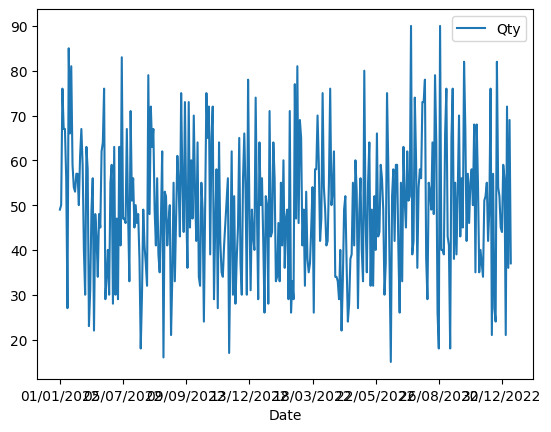

In [18]:
ts_df_2.plot() # check plot , datanya terlihat random

4. Split menjadi train dan test ( 10 % test ), pembagian dilakukan secara berurutan ( tidak diacak )  karena ini adalah time seris

In [19]:
q_90 = int(len(ts_df_2)*0.9) # ambil 10 % data terakhir untuk pemisah Train dan test nya
train_df = ts_df_2.iloc[:q_90]
test_df = ts_df_2.iloc[q_90:]






5. Membuat Baseline model ( untuk nanti membandingkan MAE nya dengan ARIMA )

In [20]:
train_df_mean = train_df.mean()
pred_df_baseline = [train_df_mean]*len(train_df)

baseline_MAE = mean_absolute_error(train_df,pred_df_baseline)


print(f"BaseLine MAE = {baseline_MAE}")

BaseLine MAE = 12.327379344932679


6. Membuat plot acf dan pacf

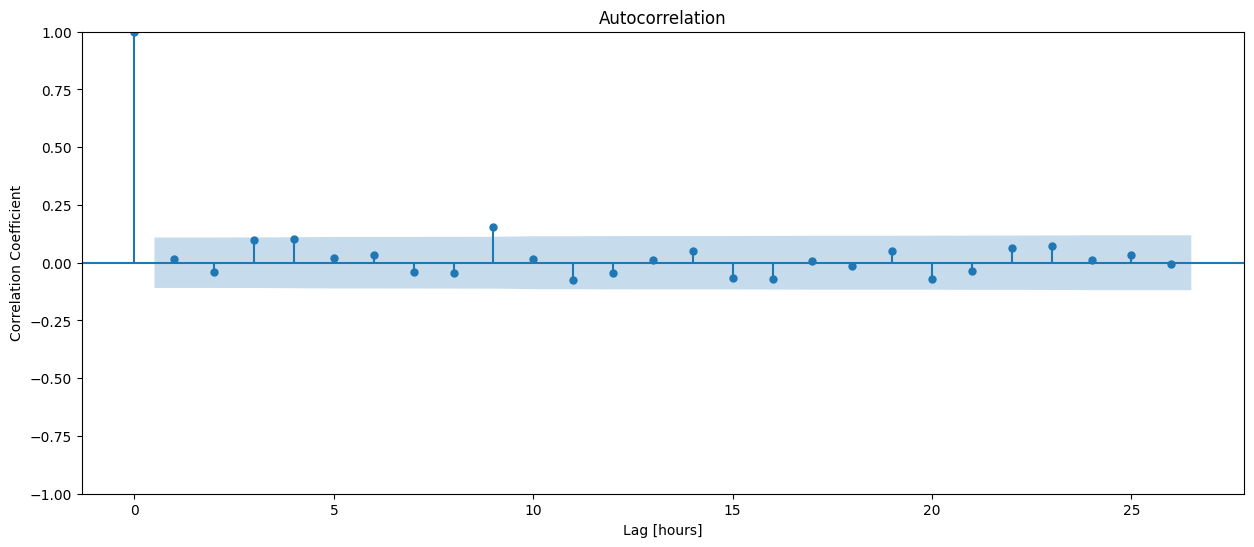

In [21]:
# membuat plot acf dan pacf dalam 1 figure
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(train_df,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

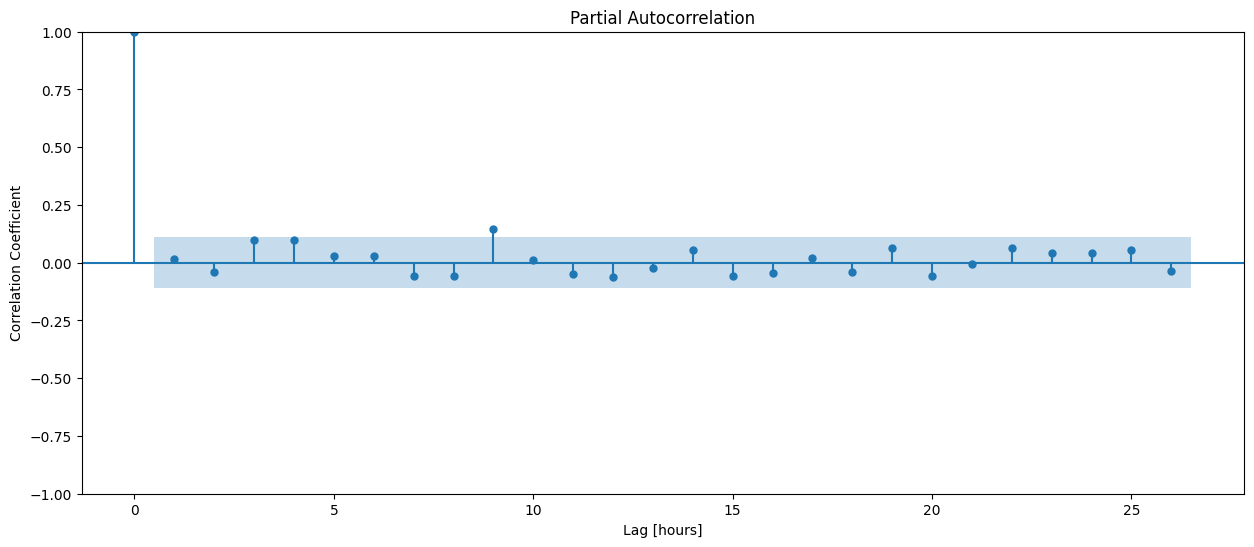

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(train_df,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

#### <font color=blue> Kesimpulan : Dari Plot ACF dan PACF, terlihat bahwa tidak ada korelasi yang signifikan bahkan pada lag pertama, sehingga kemungkinan bahwa pattern dari data adalah whitenoise ( Arima(0,0,0)) , sehingga tidak bisa di prediksi menggunakan model time series ( mungkin perlu melakukan pre-processing step lain untuk membuat datanya stasioner dan tidak behave seperti whitenoise ). Oleh sebab itu, ketika hendak memprediksi nilai penjualan hari berikutnya, maka bisa menggunakan rataan dari data tersebut secara langsung  </font>

### <font color=red> CLUSTERING </font>

In [23]:
# dimulai dari data gabungan merge_df_2 dan diambil customerID,  transactionID, qty, total_amount

clus_df = merged_df_2.copy()


In [24]:
clus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    5020 non-null   object 
 1   CustomerID       5020 non-null   int64  
 2   Date             5020 non-null   object 
 3   ProductID        5020 non-null   object 
 4   Price            5020 non-null   int64  
 5   Qty              5020 non-null   int64  
 6   TotalAmount      5020 non-null   int64  
 7   StoreID          5020 non-null   int64  
 8   CustomerIDright  5007 non-null   float64
 9   Age              5007 non-null   float64
 10  Gender           5007 non-null   float64
 11  Marital Status   5007 non-null   object 
 12  Income           5007 non-null   object 
 13  StoreIDright     4674 non-null   float64
 14  StoreName        4674 non-null   object 
 15  GroupStore       4674 non-null   object 
 16  Type             4674 non-null   object 
 17  Latitude      

1. Group data by CustomerID

In [25]:
clus_df_2 = clus_df[["CustomerID","TransactionID","Qty","TotalAmount"]]
clus_df_3 = clus_df_2.groupby("CustomerID").agg({'TransactionID':'count','Qty':'sum','TotalAmount':'sum'})

In [26]:
clus_df_3

,TransactionID,Qty,TotalAmount
CustomerID,,,
1,17,60,623300
2,13,57,392300
3,15,56,446200
4,10,46,302500
5,7,27,268600
...,...,...,...
443,16,59,485100
444,18,62,577700
445,18,68,587200


2. Cari jumlah cluster optimum

In [27]:
wcss = [] # within cluster sum of square
for i in range(1,10):
  model = KMeans(n_clusters=i)
  model.fit(clus_df_3)
  wcss.append(model.inertia_)

/home/lurah11/rakamin/pbi_kalbe/pbi_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lurah11/rakamin/pbi_kalbe/pbi_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lurah11/rakamin/pbi_kalbe/pbi_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lurah11/rakamin/pbi_kalbe/pbi_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1

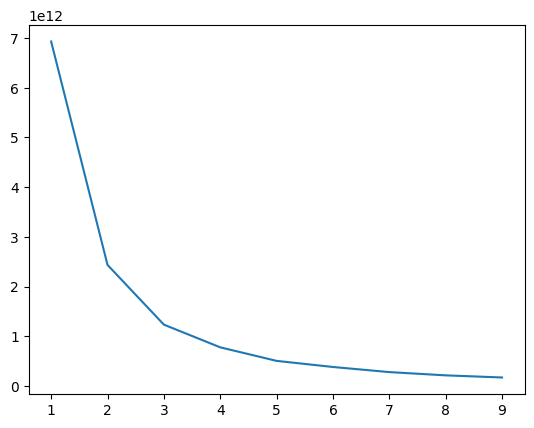

In [28]:
plt.plot(range(1,10),wcss)

<font color=blue>Jumlah cluster yang optimal adalah 5</font>

3. Membuat model dengan jumlah cluster sesuai dengan point 5

In [29]:
model_final = KMeans(n_clusters=5)
model_final.fit(clus_df_3)
final_cluster_df = clus_df_3.copy()
final_cluster_df["cluster"] = model_final.labels_
print(final_cluster_df.head())

            TransactionID  Qty  TotalAmount  cluster
CustomerID                                          
1                      17   60       623300        3
2                      13   57       392300        4
3                      15   56       446200        1
4                      10   46       302500        2
5                       7   27       268600        2


/home/lurah11/rakamin/pbi_kalbe/pbi_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


4. Visualisasi dengan menggunakan plot 3d dari plotly express

In [31]:
px.scatter_3d(final_cluster_df,x="TransactionID",y="Qty",z="TotalAmount",color="cluster")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': ('TransactionID=%{x}<br>Qty=%{y}' ... '%{marker.color}<extra></extra>'),
              'legendgroup': '',
              'marker': {'color': array([3, 4, 1, ..., 3, 4, 1], dtype=int32),
                         'coloraxis': 'coloraxis',
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'scene': 'scene',
              'showlegend': False,
              'type': 'scatter3d',
              'x': array([17, 13, 15, ..., 18, 11, 13]),
              'y': array([60, 57, 56, ..., 68, 42, 42]),
              'z': array([623300, 392300, 446200, ..., 587200, 423300, 439300])}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'cluster'}},
                             'colorscale': [[0.0, '#0d0887'], [0.1111111111111111,
                                            '#46039f'], [0.2222222222222222,
                                            '#7201a8'], [0.3333333333333333,
                                            '#9c179e'], [0.4444444444444444,
                                            '#bd3786'], [0.5555555555555556,
                                            '#d8576b'], [0.6666666666666666,
                                            '#ed7953'], [0.7777777777777778,
                                            '#fb9f3a'], [0.8888888888888888,
                                            '#fdca26'], [1.0, '#f0f921']]},
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'scene': {'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]},
                         'xaxis': {'title': {'text': 'TransactionID'}},
                         'yaxis': {'title': {'text': 'Qty'}},
                         'zaxis': {'title': {'text': 'TotalAmount'}}},
               'template': '...'}
})

#### <font color=blue> Kesimpulan : Berdasarkan hasil clustering 3d, tampak bahwa customer yang banyak melakukan transaksi, banyak membeli dalam jumlah besar, dan juga menghabiskan uang dalam jumlah besar terkumpul menjadi satu di cluster berwana pink(cluster no 2) sementara sebaliknya yang paling sedikit dari 3 parameter tadi, berkumpul di cluster kuning ( cluster no 4)  </font>